# 08 - 工具变量

## 绕过省略变量偏差（OVB）

控制OVB的一种方法是，将省略的变量添加到我们的模型中。但是，这并不总是可能的，主要是因为我们根本没有关于省略变量的数据。例如，让我们回到教育对工资影响的模型：

$
\log(hwage)_i = \beta_0 + \kappa \ educ_i + \pmb{\beta} Ability_i + u_i
$

为了弄清楚教育对 \\( \log(hwage)\\)的因果效应 \\(\kappa\\)，我们需要控制能力因素\\(Ability_i\\)。如果我们不这样做，我们可能会有一些偏差，毕竟，能力可能是一个混淆因子，同时影响干预变量：教育，以及结果变量：收入。

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr
from linearmodels.iv import IV2SLS

%matplotlib inline

pd.set_option("display.max_columns", 5)
style.use("fivethirtyeight")

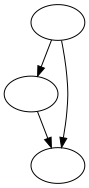

In [2]:
g = gr.Digraph()

g.edge("能力", "教育")
g.edge("能力", "工资")
g.edge("教育", "工资")
g

避免这种情况的一种方法是在衡量教育对工资的影响时控制恒定的能力水平。我们可以通过在线性回归模型中包含能力来做到这一点。但是，我们没有很好的能力衡量标准。我们拥有的最好的是一些非常可疑的代理，比如智商。

但一切都没有失去。这是工具变量进入图片的地方。IV的想法是找到导致治疗的另一个变量，并且它仅与治疗结果相关。另一种说法是，此工具 \\(Z_i\\) 与 \\(Y_0\\) 不相关，但它与 \\(T\\) 相关。这有时称为排除限制。

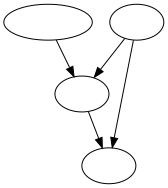

In [22]:
g = gr.Digraph()

g.edge("能力", "教育")
g.edge("能力", "工资")
g.edge("教育", "工资")
g.edge("工具变量", "教育")
g

如果我们有这样的变量，我们可以用我们将看到的 IV 公式恢复因果效应 \\(\kappa\\)。为此，让我们考虑一下我们想要运行的理想方程。使用更一般的术语，如 \\(T\\) 干预变量和 \\(W\\) 混淆因子，这是我们想要的：

$
Y_i = \beta_0 + \kappa \ T_i + \pmb{\beta}W_i + u_i
$

但是，我们没有 \\(W\\) 上的数据，所以我们只能运行

$
Y_i = \beta_0 + \kappa\ T_i + v_i
$

$
v_i = \pmb{\beta}W_i + u_i
$

由于 \\(W\\) 是一个混淆银子，所以 \\(Cov(T, v) \neq 0\\)。我们有一个短而不长的等式。在我们的示例中，这意味着能力与教育相关。如果是这种情况，由于省略了变量，运行短回归将产生 \\(\kappa\\) 的有偏估计量。

现在，看看 IV 的魔力吧！由于工具 \\(Z\\) 仅与通过 \\(T\\) 的结果相关，这意味着 \\(Cov(Z,v) = 0\\)，否则会有从 \\(Z\\) 到 \\(Y\\) 到 \\(W\\) 的第二条路径。考虑到这一点，我们可以写

$
Cov(Z,Y) = Cov(Z,\beta_0 + \kappa\ T_i + v_i) = \kappa Cov(Z,T) + Cov(Z, v) = \kappa Cov(Z,T)
$

将每一边除以 \\(V(Z_i)\\) 并重新排列项，我们得到

$
\kappa = \dfrac{Cov(Y_i, Z_i)/V(Z_i)}{Cov(T_i, Z_i)/V(Z_i)} = \dfrac{\text{Reduced Form}}{\text{1st Stage}}
$

请注意，分子和分母都是回归系数（协方差除以方差）。分子是 Y 对 Z 的回归结果。换句话说，它是 Z 对 Y 的“影响”。请记住，这并不是说 Z 导致 Y，因为我们要求 Z 仅通过T。相反，它只是捕捉 Z 对 Y 到 T 的这种影响有多大。这个分子非常有名，它有自己的名字：简化形式系数。

分母也是回归系数。这次是T对Z的回归。这个回归捕捉到Z对T的影响是什么，它也非常有名，被称为第一阶段系数。

看待这个方程的另一种很酷的方式是偏导数。我们可以证明 T 对 Y 的影响等于 Z 对 Y 的影响，按 Z 对 T 的影响进行缩放：

$
\kappa = \dfrac{\frac{\partial y}{\partial z}}{\frac{\partial T}{\partial z}} = \dfrac{\partial y}{\partial z} * \dfrac{ \partial z}{\partial T} = \dfrac{\partial y}{\partial T}
$

这向我们展示的东西比大多数人所欣赏的更微妙。它也比大多数人想象的要凉爽。通过这样写 IV，我们是在说，“看，由于混杂因素，很难找到 T 对 Y 的影响。但我可以很容易地找到 Z 对 Y 的影响，因为没有任何东西导致 Z 和 Y（排除限制）。但是，我感兴趣的是 T 对 Y 的影响，而不是 Z 对 Y 的影响。因此，我将估计 Z 对 Y 的简单影响，并通过 Z 对 T 的影响**缩放它**，将效果转换为 T 单位而不是 Z 单位”。

我们也可以在工具是虚拟变量的简化情况下看到这一点。在这种情况下，IV 估计量通过 2 个均值差异之间的比率得到进一步简化。

$
\kappa = \dfrac{E[Y|Z=1]-E[Y|Z=0]}{E[T|Z=1]-E[T|Z=0]}
$

这个比率有时被称为**Wald Estimator**。同样，我们可以告诉 IV 故事我们想要 T 对 Y 的影响，这很难得到。所以我们专注于 Z 对 Y 的影响，这很容易。根据定义，Z 仅通过 T 影响 Y，因此我们现在可以将 Z 对 Y 的影响转换为 T 对 Y 的影响。我们通过 Z 对 T 的影响缩放 Z 对 Y 的影响来实现。

## 出生季度和教育对工资的影响

到目前为止，我们一直将这些工具视为一些神奇的变量 \\(Z\\)，它们具有仅通过干预变量影响结果的神奇特性。老实说，好的工具变量来之不易，我们不妨将它们视为奇迹。让我们说它不适合胆小的人。有传言说，芝加哥经济学院的酷孩子们谈论他们是如何在酒吧里想出这种或那种工具变量的。

![img](./data/img/iv/good-iv.png)

不过，我们确实有一些有趣的工具示例，可以让事情变得更具体一些。我们将再次尝试估计教育对工资的影响。为此，我们将使用该人的出生季度作为工具 Z。

这个想法利用了美国强制出勤法。通常，他们声明孩子必须在他们入学当年的 1 月 1 日之前满 6 岁。因此，年初出生的孩子入学年龄较大。强制出勤法还要求学生在学校上学直到他们年满 16 岁，届时他们在法律上被允许退学。结果是，与年初出生的人相比，年末出生的人平均受教育年限更长。

![img](./data/img/iv/qob.png)

如果我们接受出生季度与能力因素无关，即它不会混淆教育对工资的影响，我们可以将其用作工具。换句话说，我们需要相信出生季度对工资没有影响，除了对教育的影响。如果你不相信占星术，这是一个非常有说服力的论点。

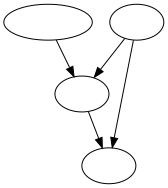

In [23]:
g = gr.Digraph()

g.edge("能力", "教育")
g.edge("能力", "工资")
g.edge("教育", "工资")
g.edge("出生季度", "教育")
g

为了进行这种分析，我们可以使用来自三次十年一次的人口普查的数据，这些数据与[Angrist和Krueger](https://economics.mit.edu/faculty/angrist/data1/data/angkru1991) 在他们关于IV的文章中使用的数据相同。该数据集包含有关日志工资，我们的结果变量以及我们的治疗变量的受教育年限的信息。它还具有有关出生季度，我们的仪器和其他控件的数据，例如出生年份和出生状态。

In [5]:
data = pd.read_csv("./data/ak91.csv")
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


## 第一阶段

在我们使用出生季度作为工具之前，我们需要确保它是有效的。这意味着支持工具变量的两个假设：

1. \\(Cov(Z， T) \neq 0 \\)。这是说我们应该有一个强大的第一阶段，或者工具变量确实会影响治疗变量。
2. \\(Y \perp Z |T \\).这是排除限制，声明工具变量Z仅通过干预T影响结果Y。

幸运的是，第一个假设是可以验证的。我们从数据中可以看出\\(Cov(Z， T)\\)不为零。在我们的例子中，如果出生的季度确实是一个工具变量，就像我们所说的那样，我们应该期望在一年中最后一个季度出生的人比年初出生的人有更多的受教育时间。在运行任何统计测试来验证这一点之前，让我们绘制我们的数据并亲眼看到它。

In [6]:
group_data = (data
              .groupby(["year_of_birth", "quarter_of_birth"])
              [["log_wage", "years_of_schooling"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))

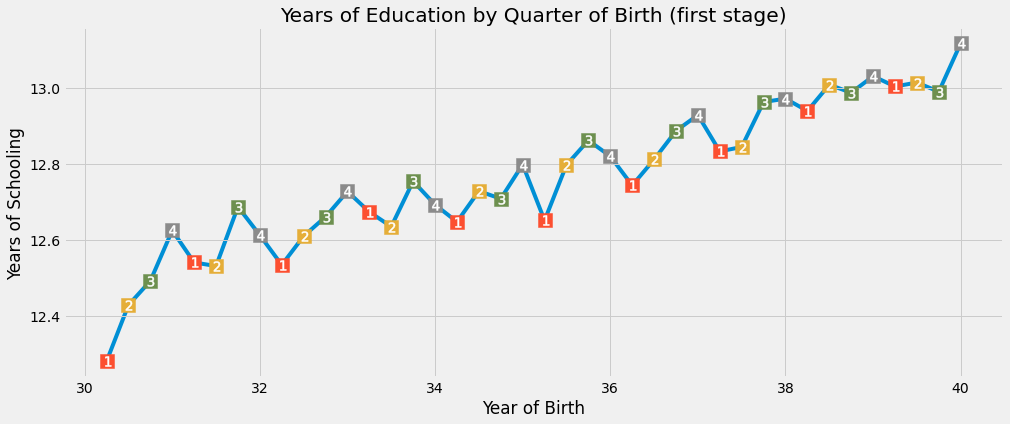

In [7]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling");

值得注意的是，在一年中的四分之一之后，学校教育的年份有一个季节性的模式。从视觉上看，我们可以看到，一年中第一季度出生的人的受教育程度几乎总是低于最后一个季度出生的人（毕竟，一旦我们控制了出生年份，那些晚年出生的人通常受教育程度更高）。

为了更严格一点，我们可以将第一阶段作为线性回归运行。我们首先将出生季度转换为虚拟变量：

In [8]:
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int)
                             for q in data["quarter_of_birth"].unique()})

factor_data.head()

,log_wage,years_of_schooling,...,q3,q4
0,5.790019,12.0,...,0,0
1,5.952494,11.0,...,0,0
2,5.315949,12.0,...,0,0
3,5.595926,12.0,...,0,0
4,6.068915,12.0,...,0,0


为简单起见，现在只使用最后一个季度，即Q4，作为工具。我们将使用干预变量：受教育年限，对工具变量：出生季度，进行回归。这将向我们展示出生在哪个季度是否确实像我们在上图中看到的那样对教育时间产生了积极影响。我们还需要在这里控制出生年份，我们将添加出生状态作为额外的控制。

In [9]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", first_stage.params["q4"])
print("q4 p-value:, ", first_stage.pvalues["q4"])

q4 parameter estimate:,  0.10085809272785906
q4 p-value:,  5.464829416638474e-15


看起来，在一年中最后一个季度出生的人平均比在一年中其他季度出生的人多受教育0.1年。p 值接近于零。这结束了关于出生在哪个季度是否导致更多或更少受教育年限的案例。

![免疫接种]（./data/img/iv/incomplete-files.png）

## 简化形式

不幸的是，我们无法验证第二种IV条件。我们只能支持它。我们可以表达我们的信念，即出生四分之一不会影响潜在的收入。换句话说，人们出生的时间并不表示他们的个人能力或任何其他可能导致收入差异的因素，除了对教育的影响。一个好方法是说，当我们考虑出生季度对收入的影响时，出生季度与随机分配一样好。（它不是随机的。有证据表明，人们倾向于在夏末或某种假期前后怀孕。但我想不出任何充分的理由表明这种模式也会以除教育以外的任何方式影响收入）。


在支持排除限制之后，我们可以继续运行简化形式。简化的形式旨在弄清楚仪器如何影响结果。由于，通过假设，所有这些影响都是由于对治疗的影响，这将为治疗如何影响结果提供一些启示。再一次，让我们在认真对待回归之前直观地评估这一点。

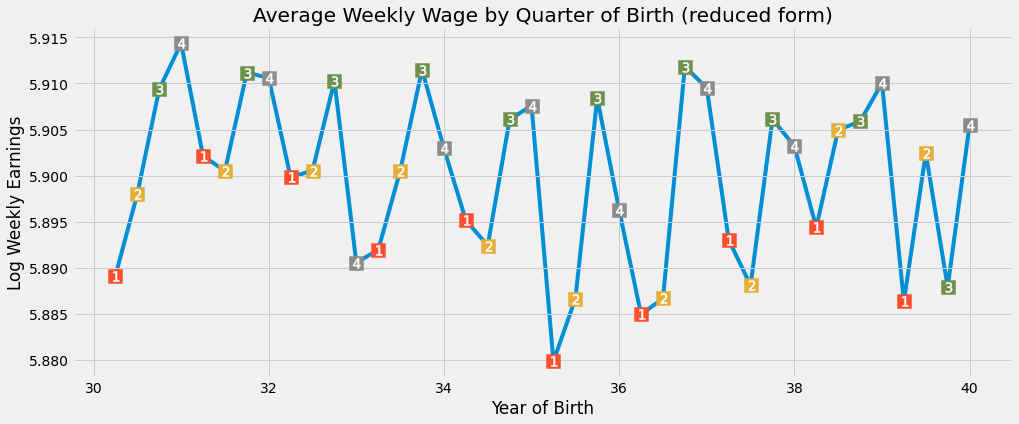

In [10]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["log_wage"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Average Weekly Wage by Quarter of Birth (reduced form)")
plt.xlabel("Year of Birth")
plt.ylabel("Log Weekly Earnings");

再一次，我们可以看到出生季度收入的季节性模式。当年晚些时候出生的人的收入略高于年初出生的人。为了验证这个假设，我们将再次在对数工资上回归工具q4。我们还将添加与第 1 阶段相同的附加控件：

In [11]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", reduced_form.params["q4"])
print("q4 p-value:, ", reduced_form.pvalues["q4"])

q4 parameter estimate:,  0.008603484260138683
q4 p-value:,  0.0014949127183684287


我们再次取得了重大成果。那些出生在今年最后一个季度的人，平均工资高出0.8%。这一次，p值不像以前那样接近于零，但它仍然非常重要，仅为0.0015。

## 手动工具变量

有了我们的简化形式和第一阶段，我们现在可以通过简化形式来缩放第一阶段的效果。由于第一阶段系数约为0.1，这将使减少的形式系数的影响乘以近10。这将给我们对平均因果效应的无偏见的IV估计：

$
ATE_{IV} = dfrac{text{Reduce Form}}{text{1st Stage}}
$

In [12]:
reduced_form.params["q4"] / first_stage.params["q4"]

0.08530286492084561

这意味着我们应该期望每增加一年的学费就会增加8%。

获得IV估计值的另一种方法是使用2个阶段最小二乘法**2SLS**。通过此过程，我们像以前一样执行第一阶段，然后运行第二阶段，其中我们用第一阶段的拟合值替换处理变量

$
educ_i = gamma_0 + gamma_1 * q4_i + gamma_2 yob_i + gamma_3 sob_i + v_i
$

$
log（wage）_i = beta_0 + beta_1 educ_i + beta_2 yob_i + beta_3 sob_i + u_i
$

$
log（wage）_i = beta_0 + beta_1 [gamma_0 + gamma_1 * q4_i + gamma_2 yob_i + gamma_3 sob_i + v_i ] + beta_2 yob_i + beta_3 sob_i + u_i
$

需要注意的一点是，**我们在执行IV**时，我们添加到第二阶段的任何其他控件也应添加到第一阶段**。

In [13]:
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

iv_by_hand.params["years_of_schooling_fitted"]

0.08530286492116357

如您所见，参数完全相同。第二种看待IV的方式对于它给出的直觉是有用的。在2SLS中，第一阶段创建一个新版本的治疗，该版本从省略的变量偏置中清除。然后，我们在线性回归中使用这种清除版本的处理，即第一阶段的拟合值。 

然而，在实践中，我们不会手工做IV。不是因为它很麻烦，而是因为我们从第二阶段得到的标准错误有点偏差。相反，我们应该总是让机器为我们完成工作。在Python中，我们可以使用[linearmodels](https://bashtage.github.io/linearmodels/)软件包 以正确的方式运行2SLS。


2SLS的公式有点不同。我们应该在公式中添加 [ ] 之间的第一个阶段。在我们的例子中，我们添加了"years_of_schooling~ q4"。不需要将其他控件添加到第一阶段，因为如果我们在第二阶段中包含其他控件，计算机将自动执行此操作。出于这个原因，我们在第一阶段的公式之外添加了"year_of_birth"和"state_of_birth"。

In [14]:
def parse(model, exog="years_of_schooling"):
    param = model.params[exog]
    se = model.std_errors[exog]
    p_val = model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se,1.96*se) + param}")
    print(f"P-value: {p_val}")
    
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
iv2sls = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv2sls)

Parameter: 0.0853028649235057
SE: 0.025540812814298396
95 CI: [0.03524287 0.13536286]
P-value: 0.0008381914659547629


再一次，我们可以看到该参数与我们之前的参数完全相同。额外的好处是，我们现在有有效的标准误差。有了这个，我们可以说，我们预计额外1年的教育平均将增加8.5%的工资。

## 多个工具变量

使用计算机的另一个优点是用于运行2SLS估计法，因为它很容易添加多个工具变量。在我们的示例中，我们将使用所有以出生季度标定的虚拟变量作为学校教育年限水平的工具变量。

In [15]:
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]'
iv_many_zs = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv_many_zs)

Parameter: 0.10769370488969798
SE: 0.019557149009493794
95 CI: [0.06936169 0.14602572]
P-value: 3.657974678716869e-08


对于所有3个虚拟变量，估计的教育回报率现在是0.1，这意味着我们应该期望每增加一年的教育收入平均增长10%。让我们将其与传统的 OLS 估计值进行比较。为此，我们可以再次使用2SLS，但现在没有第一阶段。

In [16]:
formula = "log_wage ~ years_of_schooling + C(state_of_birth) + C(year_of_birth) + C(quarter_of_birth)"
ols = IV2SLS.from_formula(formula, data=data).fit()
parse(ols)

Parameter: 0.06732572817657978
SE: 0.00038839984390486563
95 CI: [0.06656446 0.06808699]
P-value: 0.0


据估计，OLS的教育回报率低于2SLS。这表明OVB可能不像我们第一次那么强大。另外，请注意置信区间。2SLS 的 CI 比 OLS 估计值宽得多。让我们进一步探讨一下

## 工具变量的弱点

![免疫接种](./data/img/iv/weak-iv.png)

在处理IV时，我们需要记住我们是间接估计ATE的。我们的估计取决于第一阶段和第二阶段。如果治疗对结果的影响确实很强，那么第二阶段也会很强。但是，如果我们的第一阶段很弱，那么第二阶段有多强并不重要。弱的第一阶段意味着仪器与治疗的相关性非常小。因此，我们无法从仪器中学到太多有关治疗的知识。


IV标准误差的公式有点复杂，不那么直观，所以我们将尝试其他东西来掌握这个问题。我们将模拟数据，其中我们的治疗T对结果Y的影响为2.0，未观察到的混杂物U和额外的对照X。我们还将在第一阶段模拟具有不同优势的多种乐器。

$
X \sim N(0, 2^2)\\
U \sim N(0, 2^2) \\
T \sim N(1+0.5U, 5^2) \\
Y \sim N(2+ X - 0.5U + 2T， 5^2)\\
Z \sim N(T, sigma^2) \text{  for }\sigma^2 \text{ in 0.1 to 100}\\
$

In [17]:
np.random.seed(12)
n = 10000
X = np.random.normal(0, 2, n) # observable variable
U = np.random.normal(0, 2, n) # unobservable (omitted) variable
T = np.random.normal(1 + 0.5*U, 5, n) # treatment
Y = np.random.normal(2 + X - 0.5*U + 2*T, 5, n) # outcome

stddevs = np.linspace(0.1, 100, 50)
Zs = {f"Z_{z}": np.random.normal(T, s, n) for z, s in enumerate(stddevs)} # instruments with decreasing Cov(Z, T)

sim_data = pd.DataFrame(dict(U=U, T=T, Y=Y)).assign(**Zs)

sim_data.head()

,U,T,...,Z_48,Z_49
0,2.696148,8.056988,...,-117.798705,-13.485292
1,2.570240,0.245067,...,-209.727577,-70.792948
2,0.664741,5.597510,...,60.562232,47.619414
3,1.037725,0.493532,...,78.136513,-108.322304
4,-2.590591,-6.263014,...,78.776566,-80.547214


仔细检查一下，我们可以看到Z和T之间的相关性确实在下降。

In [18]:
corr = (sim_data.corr()["T"]
        [lambda d: d.index.str.startswith("Z")])

corr.head()

Z_0    0.999807
Z_1    0.919713
Z_2    0.773434
Z_3    0.634614
Z_4    0.523719
Name: T, dtype: float64

现在，我们将为每个工具变量运行一个IV模型，并收集ATE估计值和标准误差。

In [19]:
se = []
ate = []
for z in range(len(Zs)):
    formula = f'Y ~ 1 + X + [T ~ Z_{z}]'
    iv = IV2SLS.from_formula(formula, sim_data).fit()
    se.append(iv.std_errors["T"])
    ate.append(iv.params["T"])

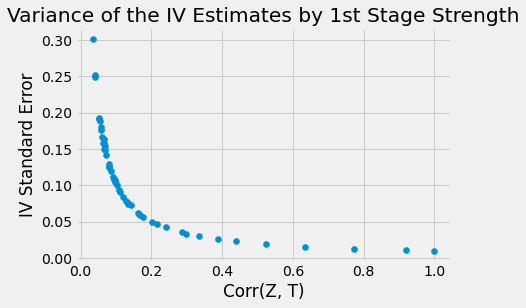

In [20]:
plot_data = pd.DataFrame(dict(se=se, ate=ate, corr=corr)).sort_values(by="corr")

plt.scatter(plot_data["corr"], plot_data["se"])
plt.xlabel("Corr(Z, T)")
plt.ylabel("IV Standard Error");
plt.title("Variance of the IV Estimates by 1st Stage Strength");

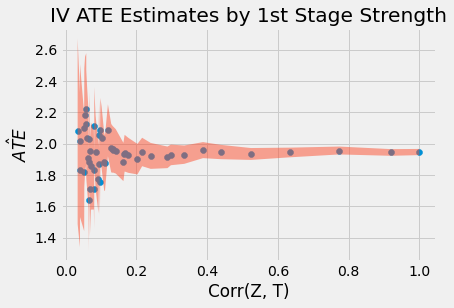

In [21]:
plt.scatter(plot_data["corr"], plot_data["ate"])
plt.fill_between(plot_data["corr"],
                 plot_data["ate"]+1.96*plot_data["se"],
                 plot_data["ate"]-1.96*plot_data["se"], alpha=.5)
plt.xlabel("Corr(Z, T)")
plt.ylabel("$\hat{ATE}$");
plt.title("IV ATE Estimates by 1st Stage Strength");

正如我们在上面的图中看到的那样，当 \\(T\\) 和 \\(Z\\) 之间的相关性较弱时，估计值会有很大差异。这是因为当相关性较低时，SE也会增加很多。

另一件需要注意的事情是**2SLS是有偏的**！即使相关性很高，参数估计值仍未达到 2.0 的真实 ATE。实际上，2.0 甚至不在 95% 的 CI 中！2SLS 仅一致，这意味着如果样本数量足够大，它将接近真实参数值。但是，我们不知道多大才足够大。我们只能坚持一些经验法则来理解这种偏见的行为方式：


1. 2SLS 偏向于 OLS。这意味着，如果 OLS 具有负/正偏差，则 2SLS 也将具有该偏差。2SLS 的优点是，在省略变量的情况下，它至少是一致的，而 OLS 则不是。在上面的例子中，我们未观察到的U对结果产生负面影响，但与治疗呈正相关，这将导致负面偏见。这就是为什么我们看到ATE估计值低于真实值（负偏差）。。

2. 偏差将随着我们添加的工具数量而增加。如果我们添加太多的工具，2SLS变得越来越像OLS。

除了知道这种偏差的行为方式之外，最后一条建议是避免在**做IV时出现一些常见错误**：

1. 手工做IV。正如我们所看到的，即使参数估计是正确的，手动IV也会导致错误的标准误差。SE 不会完全关闭。不过，如果您可以使用软件并获得正确的SE，为什么要这样做呢？

2. 在第一阶段使用OLS以外的任何东西。许多数据科学家遇到IV并认为他们可以做得更好。例如，他们看到一个虚拟的处理，并考虑用逻辑回归替换第一阶段，毕竟，他们正在预测一个虚拟变量，对吧？问题是，这显然是错误的。IV 的一致性依赖于只有 OLS 才能给出的属性，即残差的正交性，因此在第 1 阶段与 OLS 不同的任何内容都会产生偏差。（OBS：有一些现代技术使用机器学习进行IV，但它们的结果充其量是值得怀疑的）。

## 关键思想

我们在这里花了一些时间来理解如果我们有一个工具变量，我们如何解决省略的变量偏差。工具变量是与干预相关的变量（具有第一阶段），但仅通过干预（排除限制）影响结果。我们看到一个以分季度的出生率作为工具变量的例子，用于估计教育对收入的影响。

然后，我们深入研究使用IV估计因果效应的机制，即使用2SLS。我们还了解到，IV不是银弹。当我们的第一阶段很弱时，这可能会很麻烦。此外，尽管一致，但2SLS仍然是估计因果效应的有偏方法。